<a href="https://colab.research.google.com/github/Namneul/Hands-on-Machine-Learning/blob/main/Chapter%2005%20%EC%84%9C%ED%8F%AC%ED%8A%B8%20%EB%B2%A1%ED%84%B0%20%EB%A8%B8%EC%8B%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### chapter 05 서포트 벡터 머신

# 0. 서포트 벡터 머신 (SVM) support vector machine

: 매우 강력하고 선형이나 비선형 분류, 회귀, 이상치 탐색에도 사용할 수 있는 다목적 머신러닝 모델이다.

: 결정 경계, 즉 분류를 위한 기준 선을 정의하는 모델이다.





1. 선형 SVM 분류

라지 마진 분류 large margin classification


In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)


SVC(C=inf, kernel='linear')

그림 저장: large_margin_classification_plot


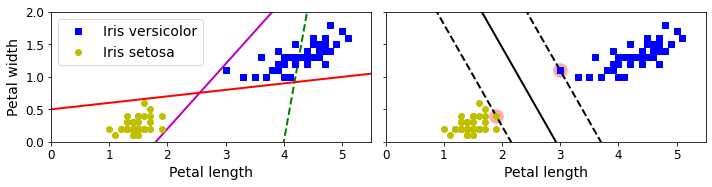

In [3]:
# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

왼쪽 그래프는 세 개의 선형 분류기에서 만들어진 결정 경계가 보인다. 점선으로 나타난 결정 경계를 만든 모델은 클래스를 적절하게 분류하지 못한다. 

오른쪽 그래프에 있는 실선은 SVM분류기의 결정 경계이다. 이 직선은 두 개의 클래스를 나누고, 훈련샘플로부터 가능한 멀리 떨어짐

- 서포트 벡터 support vector
    
    : 결정경계의 생성에 영향을 주는 샘플(오른쪽 그림에서 빨간색으로 표시된 샘플)

## 1.1 소프트 마진 분류

- 하드 마진 분류
    - 모든 샘플이 도로 바깥쪽에 잘 분류되어 있는 형태
    - 문제점
        - 데이터가 선형적으로 구분되어야 작동
        - 이상치(outlier)에 민감하다.

그림 저장: sensitivity_to_outliers_plot


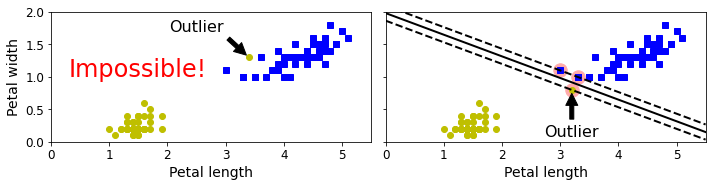

In [4]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

왼쪽 그래프는 이상치로 인해서 하드 마진을 찾을수가 없다. 

오른쪽은 이상치의 영향으로 결정경계가 이상하게 나와서 일반화에 어려움이 있다.

문제 해결 - 유연한 모델 필요.

###**소프트 마진 분류**
도로의 폭을 가능한 한 넓게 유지하는 것과 마진 오류(margin violation) 사이에 적절한 균형을 잡는 것

- 파라미터 C
    - SVM모델이 오류를 어느정도 허용할 것인지 파라미터 c를 통해 지정한다.

In [5]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [6]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [7]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

그림 저장: regularization_plot


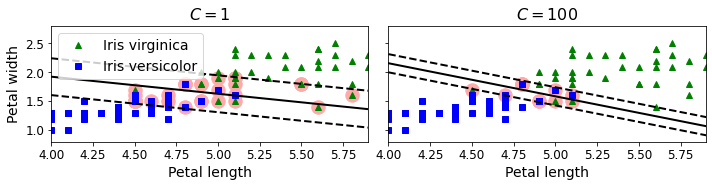

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

마진오류는 나쁘므로 일반적인 경우 적은것이 좋다. 

하지만 위 경우에는 왼쪽 모델이 마진오류가 많지만 일반화가 더 잘될것으로 보인다.

## 1.2 비선형 SVM 분류

: 비선형 데이터를 다루는 방법은 다항 특성과 같은 특성을 더 추가하는 것이다

- 선형적으로 구분되는 데이터셋이 만들어진다.

그림 저장: higher_dimensions_plot


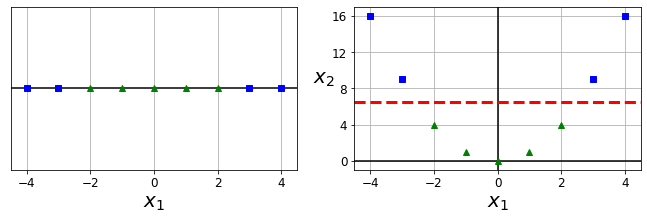

In [9]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

- 왼쪽 그래프는 하나의 특성 x1을 가진 데이터 셋→ 선형적으로 구분 x
- 오른쪽은 두번째 특성 x2= x1^2을 추가해 만들어진 2차원 데이터 셋 → 선형적으로 구분 가능

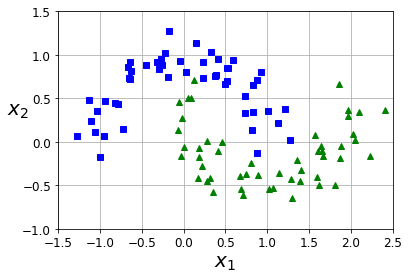

In [10]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [11]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

그림 저장: moons_polynomial_svc_plot


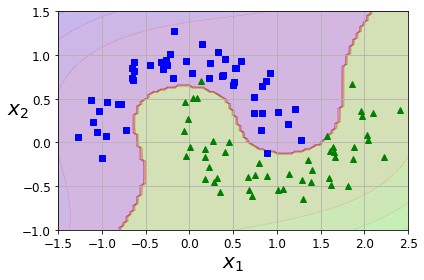

In [12]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

## 2.1 다항식 커널

다항식 특성을 추가하는것은 간단하고 모든 머신러닝 알고리즘에서 잘 작동한다.

- 하지만 낮은 차수의 다항식은 매우 복잡한 데이터셋을 잘 표현하지 못한다.
- 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만든다.

SVM을 사용할 때 **커널 트릭**이라는 수학적 기교를 적용한다. 

- 커널트릭은 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있다. (즉, 주어진 데이터를 고차원 특성 공간으로 사상해주는것이다.)


- 커널 함수를 적용 후 선형적으로 분류할 수 있는 결정 경계를 찾을 수 있게 된다.
- 실제로 특성을 추가하는 것이 아니기 떄문에 엄청난 수의 특성 조합이 생기는 것이 아님

In [13]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [14]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

그림 저장: moons_kernelized_polynomial_svc_plot


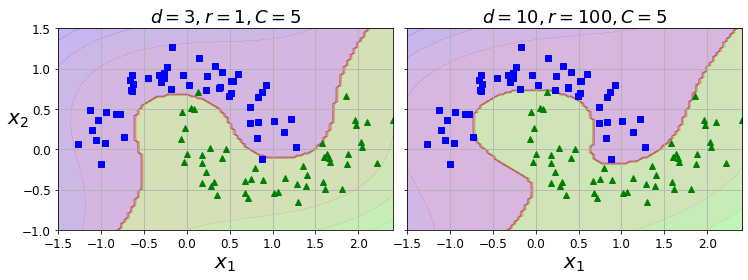

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

- SVC클래스 사용
- 왼쪽은 d=3 즉 3차 다항식커널을 사용해 SVM 분류기를 훈련시킴
- 오른쪽은 10차 다항식 커널을 사용함
- 모델이 과대적합이라면 다항식 차수를 줄이고, 과소적합이면 늘려야한다.
- 매개변수 coef()는 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절(default=0)

## 2.2 유사도 특성

비선형 특성을 다루는 다른 기법은 각 샘플이 특정 랜드마크와 얼마나 닮았는지 측정하는 유사도 함수로 계산한 특성을 추가하는것 

그림 저장: kernel_method_plot


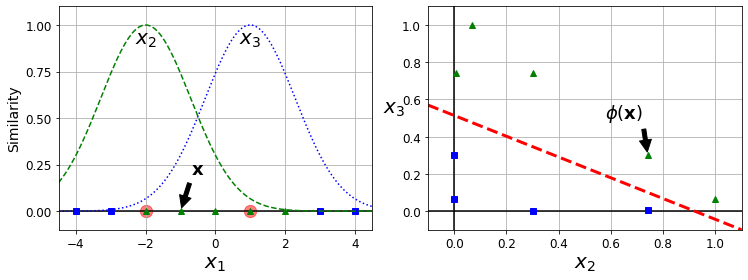

In [16]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

예를 들어 앞에서 본 데이터셋에 두 개의 랜드마크 x1=-2 와 x2=1을 추가한다. (위 왼쪽 그래프)
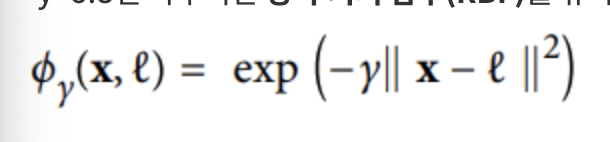





y=0.3인 가우시안 방사 기저 함수(RBF)를 유사도 함수로 정의  

- 이 함수의 값은 0 (랜드마크에서 아주 멀리 떨어진 경우)부터 1(랜드마크와 같은 위치일 경우) 까지 변화하며 종 모양으로 나타남
  
  -x1이 -2 에 가까울 수록 1에 가까워짐

  -x1=-1 샘플은 첫 번째 랜드마크에서 1만큼 떨어져 있고 두번째 랜드마크에서 2만큼 떨어져 있다
    - 따라서 새로 만든 특성은x2=exp(-0.3x1^2)와 x3=ㄷ테(-0.3x2^2)
    - 위 오른쪽 그래프는 변환된 데이터셋을 보여줌(원본 특성 제외)-> 선형적으로 구분이 가능

**랜드마크를 선택하는 방법**
- 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정

    - 차원이 매우 커지고 따라서 변환된 훈련세트가 
      선형적으로 구분될 가능성이 높다.
    - 단점은 훈련세트에 있는 n개의 특성을 가진 m개의 샘플이 m 개의 특성을 가진 m개의 샘플로 변환된다.
    - 훈련세트가 매우 클 경우 동일한 크기의 아주 많은 특성이 만들어짐


## 2.3 가우시안 RBF 커널

  가우시안 RBF커널은 다항 특성 방식과 마찬가지로 유사도 특성 방식도 머신러닝 알고리즘에 유용하게 사용한다.
  - 추가특성을 모두 계산하려면 연산 비용이 많이 들어감(훈련세트가 클 경우 특히 더)
  - 여기서 커널 트릭을 이용하면 유사도 특성을 많이 추가하는 것과 같은 결과를 얻는다.

In [17]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

그림 저장: moons_rbf_svc_plot


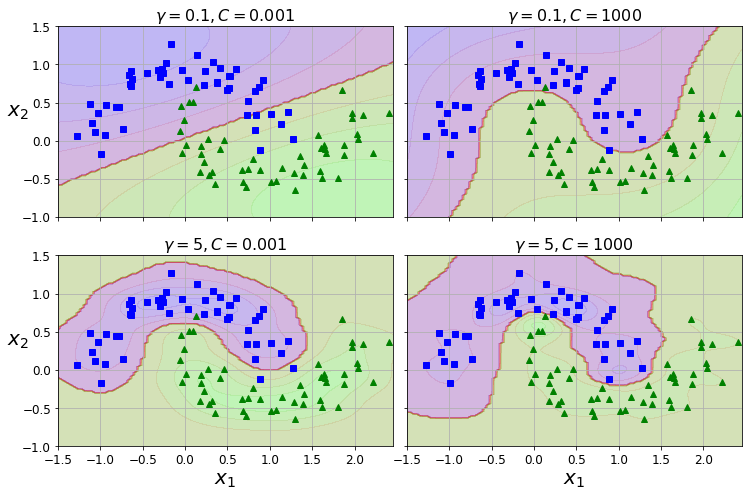

In [18]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

- gamma(γ)를 증가시키면 종 모양 그래프가 좁아져서 샘플의 영향 범위가 작아진다.
- 작은 gamma(γ) 값은 넓은 종 모양 그래프를 만들며 샘플이 넓은 범위에 걸쳐 영향을 준다.

 → 하이퍼파라미터 γ가 규제의 역할을 한다. 

다른 커널들은 거의 사용되지 않는다.
- 문자열 커널
  + 텍스트 문서, DNA 서열을 분류할 때 사용된다.
    * ex) 문자열 서브시퀀스 커널, 레벤슈타인 거리기반 커널

## 2.4 계산 복잡도

**SVC :** 커널 틕 알고리즘을 구현한 libsvm 라이브러리를 기반으로 한다.
- 훈련의 시간 복잡도는 보통 O(m<sup>2</sup> x n)과 O(m<sup>3</sup> x n) -> 훈련 샘플 수가 커지면 엄청나게 느려진다는 것을 의미한다.

- 복잡하지만 작거나 중간 규모의 훈련 세트에 이 알고리즘이 잘 맞는다.
- 특성이 **희소 특성**인 경우에는 잘 확장된다.

## 3. SVM 회귀

SVM 알고리즘은 분류뿐만 아니라 회귀에도 사용할 수 있다. 회귀에 적용하는 방법은 **목표를 반대로 하는 것**이다.

도로 폭을 가능한 한 최대로 만드는 목표 대신, SVM 회귀는 제한된 마진 오류 안에서 **도로 안에 가능한 한 많은 샘플이 들어가도록** 학습한다.
- 도로의 폭은 하이퍼파라미터 `ε`으로 조절한다.


그림 저장: svm_regression_plot


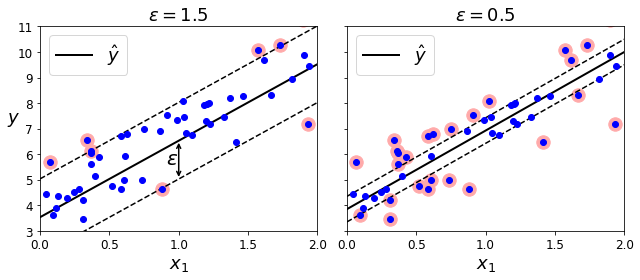

In [19]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

### 선형 회귀 작업
위의 그림은 무작위로 생성한 선형 데이터셋에 훈련시킨 선형 SVM 회귀 모델이다.

마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없다.
-> 따라서 이 모델을 **ε에 민감하지 않다**고 말한다.

그림 저장: svm_with_polynomial_kernel_plot


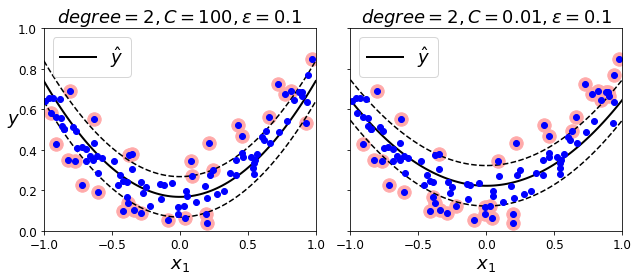

In [20]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

###비선형 회귀 작업

위의 사진은 임의의 2차방정식 형태의 훈련 세트에 2차 다항 커널을 사용한 SVM 회귀이다.

- 비선형 회귀 작업은 커널 SVM 모델을 사용하여 처리한다.
- 왼쪽 그래프는 규제가 거의 없고, 오른쪽 그래프는 규제가 훨씬 많다.
- 위의 그래프를 만들때 사용한 SVR은 SVC의 회귀 버전으로, SVC와 같이 훈련 세트의 크기가 커지면 필요한 시간이 늘어난다. 

# 4. SVM 이론

- 표기법 정리
  - 모델 파라미터 : θ
  - 모든 샘플의 편향에 해당하는 입력값 추가 : $x_0 = 1$
  - 편향 : $b$
  - 특성의 가중치 벡터 : $w$

## 4.1 결정 함수와 예측

선형 SVM 분류기 모델은 단순히 결정 함수를 계산해서 새로운 샘플 $x$의 클래스를 예측한다.

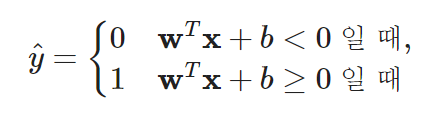

그림 저장: iris_3D_plot


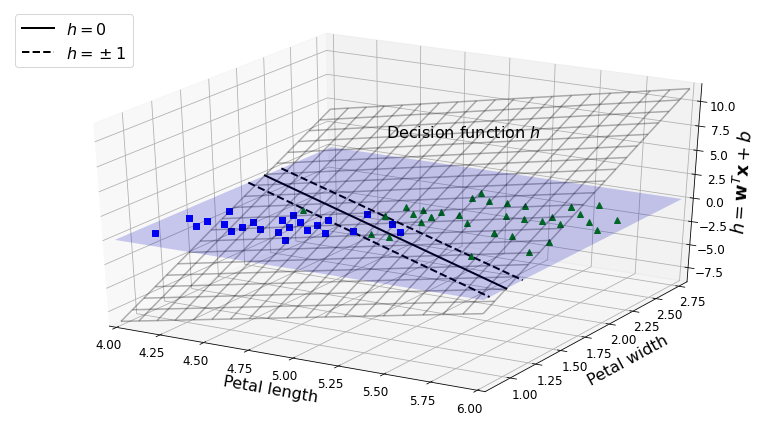

In [21]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

위의 그림은 그림 5-4의 오른쪽 모델의 결정 함수를 나타낸 것이다. 특성이 두 개인 데이터셋이기 때문에 2차원 평면이다. 
- 결정 경계는 결정 함수의 값이 0인 점들로 이루어져 있다.
- 이는 두 평면의 교차점으로, 직선이다. (굵은 실선으로 나타내었다.)
- 점선은 결정 함수의 값이 1 또는 -1인 점들을 나타낸다. -> 결정 경계에 나란하고 일정한 거리만큼 떨어져서 마진을 형성하고 있다.

**선형 SVM 분류기 훈련 :**마진 오류를 하나도 발생하지 않거나(하드 마진) 제한적인 마진 오류를 가지면서(소프트 마진) **가능한 한 마진을 크게 하는 $w$와 $b$를 찾는 것이다.**

## 4.2 목적 함수


그림 저장: small_w_large_margin_plot


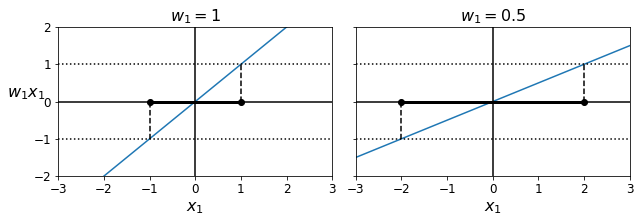

In [22]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

결정 함수의 기울기는 가중치 벡터의 노름 $||w||$와 같다.
이 기울기를 2로 나누면 결정 함수의 값이 $±1$이 되는 점들이 결정 경계로부터 2배만큼 더 멀어진다.

즉,
**기울기를 2로 나누는 것은 마진에 2를 곱하는 것과 같다.**


#### 하드 마진 선형 SVM 분류기의 목적 함수

마진을 크게 하기 위해 $||w||$를 최소화하려고 한다.
- 마진 오류를 하나도 만들지 않으려면(하드 마진):
  - 결정 함수가 모든 양성 훈련 샘플에서는 1보다 커야 한다.
  - 음성 훈련 샘플에서는 -1 보다 작아야한다.

이 때, 음성 샘플($y^{(i)} = 0 $)일 때 $t^{(i)} = -1$로, 양성 샘플($y^{(i)} = 1 $)일 때 $t^{(i)} = 1$로 정의하면
제약 조건을 **모든 샘플에서 $t^{(i)}(w^Tx^{(i)}+b)≥1$로 표현**할 수 있다.

그러므로, 하드 마진 선형 SVM 분류기의 목적 함수를 아래와 같은 제약이 있는 최적화 문제로 표현할 수 있다.

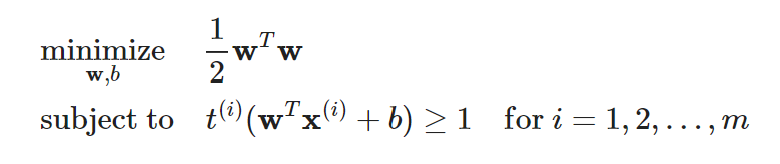

#### 소프트 마진 분류기의 목적 함수

이 함수를 구성하기 위해선 각 샘플에 대해 **슬랙 변수 ≥ 0**을 도입해야 한다.
슬랙 변수는 $i$번째 샘플이 얼마나 마진을 위반할지 정한다. 

이 문제는 두 개의 상충되는 목표를 가진다.
- 마진 오류를 최소화하기 위해 가능한 한 슬랙 변수의ㅣ 값을 작게 만드는 것
- 마진을 크게 하기 위해 ${1\over2}w^Tw$를 가능한 한 작게 만드는 것

**하이퍼 파라미터 C :** 두 목표 사이의 트레이드오프를 정의한다.

## 4.3 콰드라틱 프로그래밍

하드 마진과 소프트 마진 문제는 모두 선형적인 제약 조건이 있는 볼록 함수의 이차 최적화 문제이다.

이런 문제를 **콰드라틱 프로그래밍(QP)** 문제라고 한다.

일반적으로 QP 문제를 푸는 알고리즘은 아래의 식과 같다.

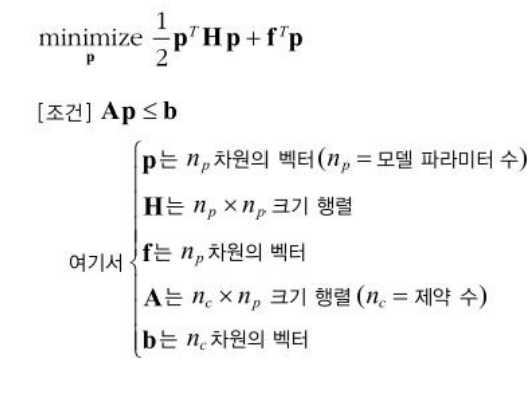

식 $Ap ≤ b$는 $n_c$개의 제약을 정의하고 있다.
i = 1, 2, ~,$n_c$일 때 $p^Ta^{(i)}≤b^{(i)}$인 제약이 있는데, 여기서 $a^{(i)}$는 $A$의 $i$번째 행의 원소를 포함하는 벡터이고, $b^{(i)}$는 $b$의 $i$번째 원소이다.

다음과 같이 QP 파라미터를 지정하면 하드 마진을 갖는 선형 SVM 분류기의 목적 함수를 간단하게 검증할 수 있다.

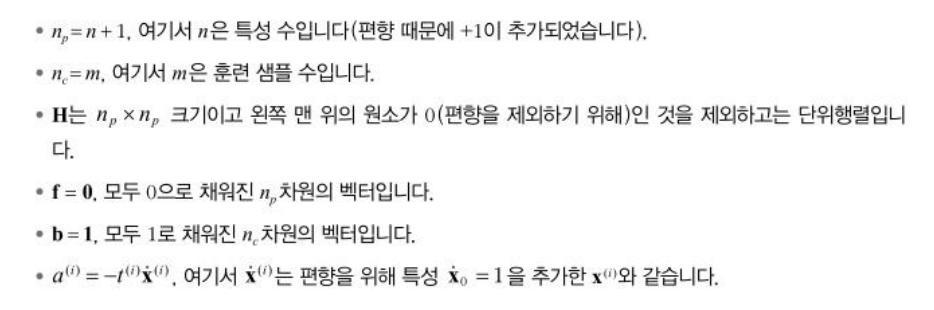

하드 마진 선형 SVM 분류기를 훈련시키는 한 가지 방법은 이미 준비되어 있는
**QP 알고리즘에 관련 파라미터를 전달하는 것**이다.
결과 벡터 p는 편향 $b=p_0$와 특성 가중치 $w_i=p_i$를 담고 있다.


## 4.4 쌍대 문제

**원 문제**라는 제약이 있는 최적화 문제는 **쌍대 문제**라고 하는 깊게 관련된 다른 문제로 표현할 수 있다.

특정 조건하에서 쌍대 문제는 원 문제와 똑같은 해를 제공하는데, SVM 문제는 이 조건을 만족시키기 때문에 쌍대 문제 또한 선택하여 풀 수 있다.


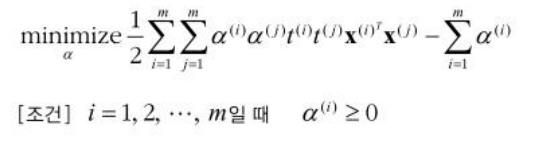

위의 식이 선형 SVM 목적 함수의 쌍대 형식이다.

이 식을 최소화하는 벡터 $â$을 찾았다면, 아래의 식을 사용해 원 문제의 식을 최소화하는 $ŵ$와$b̂$을 계산할 수 있다.

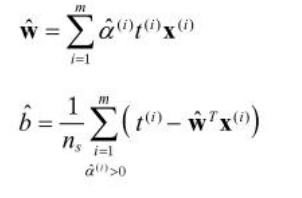

훈련 샘플 수 ≤ 특성 개수 라면 원 문제보다 쌍대 문제를 푸는 것이 더 빠르다.

더 중요한 것은 원 문제에서는 적용되지 않는 **커널 트릭을 가능하게 한다.**

## 4.5 커널 SVM

2차원 데이터셋에 2차 다항식 변환을 적용하고 선형 SVM 분류기를 변환된 이 훈련 세트에 적용한다고 하자.

아래의 식은 우리가 적용하고자 하는 2차 다항식 매핑 함수 ϕ이다.


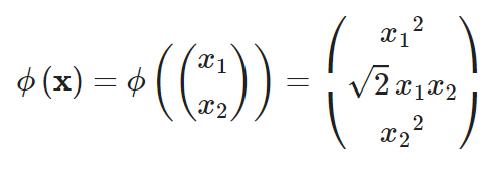

변환된 벡터는 3차원이 된다. 두 개의 2차원 벡터 a와 b에 2차 다항식 매핑을 적용한 다음 변환된 벡터로 점곱을 한 결과를 보자.

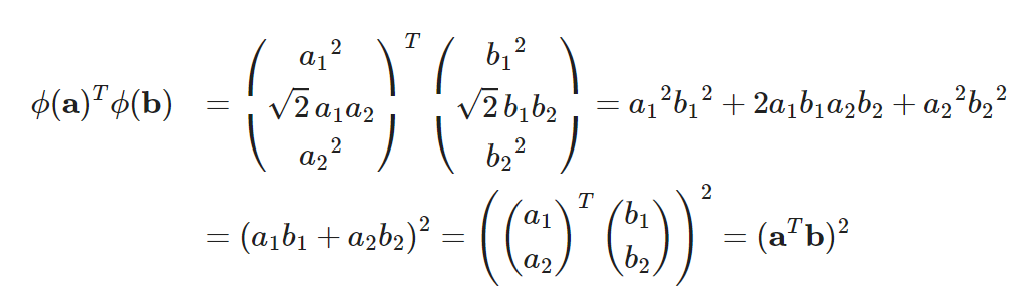

변환된 벡터의 점곱이 원래 벡터의 점곱의 제곱과 같다.

$ϕ(a)^Tϕ(b) = (a^Tb)^2$

**핵심은** 모든 훈련 샘플에 변환 ϕ를 적용하면 쌍대 문제에 점곱 $ϕ(x^{(i)})^Tϕ(x^{(j)})$가 포함이 되는데, 이 때 ϕ가 위의 식에 정의된 2차 다항식 변환 ϕ이라면 변환된 벡터의 점곱을 간단하게 $(x^{(i)^T}x^{(j)})^2$으로 바꿀 수 있다.

즉, 선형 SVM 목적 함수의 쌍대 형식의 점곱을 제곱으로 바꾸기만 하면 된다.

이 때의 결과값은 실제로 훈련 샘플을 변환해서 선형 SVM 알고리즘을 적용하는 것과 완전히 똑같다.

하지만 이 기법이 **전체 과정에 필요한 계산량 측면에서 훨씬 효율적**이다.

이것을 바로 **커널 트릭**이라고 한다.

함수 $K(a,b)=(a^Tb)^2$을 2차 **다항식 커널**이라고 부른다. 

머신러닝에서 **커널**은 변환 ϕ를 계산하지 않고 원래 벡터 a와 b에 기반하여 점곱 $ϕ(a)^Tϕ(b)$를 계산할 수 있는 함수이다.

아래의 식들은 가장 널리 사용되는 커널의 일부이다.

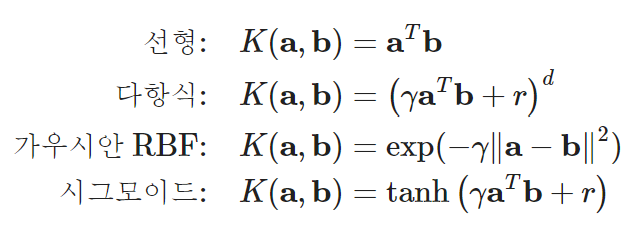

선형 SVM 분류기의 경우, 쌍대 문제를 풀 때 커널 트릭을 사용한다면 결국 예측 식에 $ϕ(x^{(i)})$를 포함해야 한다.

그렇게 된다면 $ŵ$을 계산할 수 없게 되는데, 이 때는 $ŵ$을 모르는 채로 예측을 만든다.

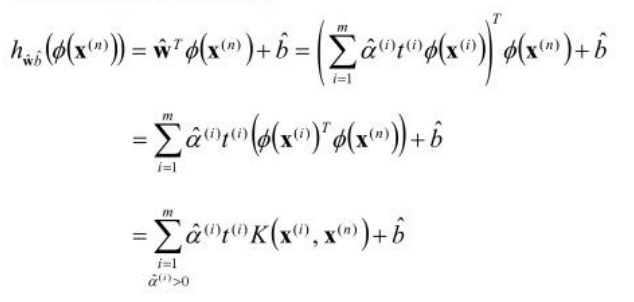

서포트 벡터만 $α^{(i)}≠0$이기 때문에 예측을 만들 때 서포트 벡터와 새 입력 벡터 $x^{(n)}$간의 점곱만 계산하면 된다.

이 때 편향 b̂도 커널 트릭을 사용해 계산해야 한다.

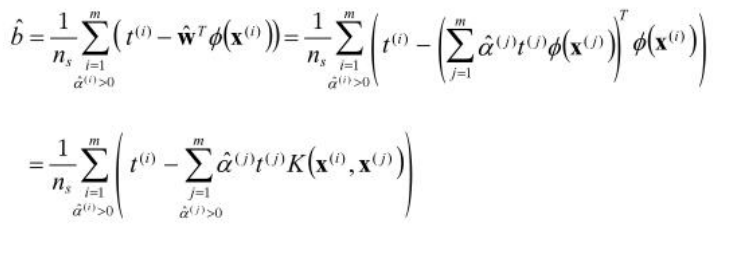

## 4.6 온라인 SVM

온라인 SVM 분류기를 구현하는 한 방법은 원 문제로부터 유도된 비용 함수(아래의 식)을 최소화하기 위한 **경사 하강법을 사용**하는 것이다.

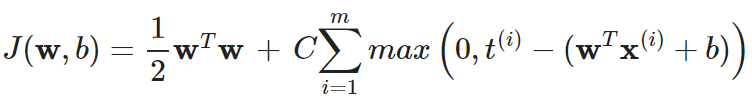

이 비용 함수의 첫 번째 항은 모델이 작은 가중치 벡터 $w$를 가지도록 제약을 가해 마진킁 크게 만든다.

두 번째 항은 모든 마진 오류를 계산한다. -> 샘플이 도로에서 올바른 방향으로 벗어나 있다면 마진 오류는 0이다.